AUC: 0.956


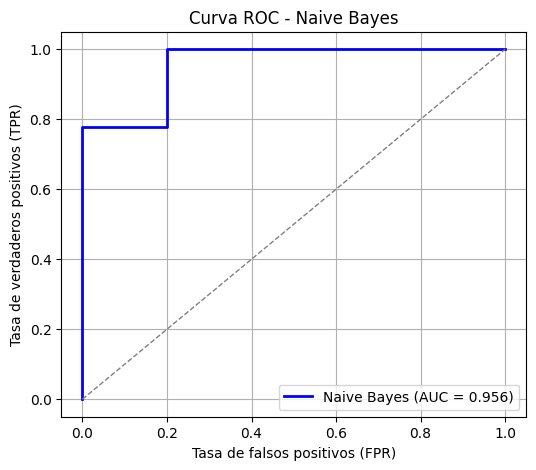

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

# Dataset de ejemplo
data = {
    'Clima': ['Soleado', 'Soleado', 'Nublado', 'Lluvia', 'Lluvia', 'Lluvia',
              'Nublado', 'Soleado', 'Soleado', 'Lluvia', 'Soleado', 'Nublado', 'Nublado', 'Lluvia'],
    'Temperatura': ['Caliente', 'Caliente', 'Caliente', 'Templado', 'Frío', 'Frío',
                    'Frío', 'Templado', 'Frío', 'Templado', 'Templado', 'Templado', 'Caliente', 'Templado'],
    'Humedad': ['Alta', 'Alta', 'Alta', 'Alta', 'Normal', 'Normal', 'Normal',
                'Alta', 'Normal', 'Normal', 'Normal', 'Alta', 'Normal', 'Alta'],
    'Viento': ['Débil', 'Fuerte', 'Débil', 'Débil', 'Débil', 'Fuerte', 'Fuerte',
               'Débil', 'Débil', 'Débil', 'Fuerte', 'Fuerte', 'Débil', 'Fuerte'],
    'Jugar': ['No', 'No', 'Sí', 'Sí', 'Sí', 'No', 'Sí', 'No', 'Sí', 'Sí', 'Sí', 'Sí', 'Sí', 'No']
}

df = pd.DataFrame(data)

# Separar características (X) y etiqueta (y)
X = df[['Clima', 'Temperatura', 'Humedad', 'Viento']]
y = df['Jugar']

# Implementación sencilla de Naive Bayes


class NaiveBayes:
    def fit(self, X, y):
        self.classes = np.unique(y)
        self.likelihoods = {}
        self.priors = {}

        for c in self.classes:
            X_c = X[y == c]
            self.priors[c] = len(X_c) / len(X)
            self.likelihoods[c] = {}
            for col in X.columns:
                probs = X_c[col].value_counts(normalize=True).to_dict()
                self.likelihoods[c][col] = probs

    def predict_proba(self, X_test):
        """Devuelve la probabilidad de cada clase"""
        probas = []
        for _, x in X_test.iterrows():
            posteriors = {}
            for c in self.classes:
                prior = np.log(self.priors[c])
                likelihood = 0
                for col, val in x.items():
                    likelihood += np.log(self.likelihoods[c]
                                         [col].get(val, 1e-6))
                posteriors[c] = prior + likelihood
            # Convertir log-probs a probas normales (softmax)
            exp_values = np.exp(list(posteriors.values()))
            probs = exp_values / np.sum(exp_values)
            probas.append(dict(zip(self.classes, probs)))
        return probas

    def predict(self, X_test):
        probas = self.predict_proba(X_test)
        return [max(p, key=p.get) for p in probas]


# Entrenar el modelo
nb = NaiveBayes()
nb.fit(X, y)

# Evaluar usando todo el dataset (por simplicidad)
probas = nb.predict_proba(X)
y_pred = nb.predict(X)

# Calcular probabilidades de la clase positiva
y_true_bin = label_binarize(y, classes=['No', 'Sí']).ravel()
y_scores = [p['Sí'] for p in probas]

# Calcular AUC y curva ROC
auc = roc_auc_score(y_true_bin, y_scores)
fpr, tpr, thresholds = roc_curve(y_true_bin, y_scores)

print("AUC:", round(auc, 3))

# Graficar la curva ROC
plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'Naive Bayes (AUC = {auc:.3f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=1)
plt.xlabel('Tasa de falsos positivos (FPR)')
plt.ylabel('Tasa de verdaderos positivos (TPR)')
plt.title('Curva ROC - Naive Bayes')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
